In [ ]:
!pip install torch-scatter torch-sparse
!pip install torch-geometric-temporal
!pip install torch-geometric==2.4.0
!pip install torch-geometric-temporal
from torch_geometric_temporal.dataset import METRLADatasetLoader
import torch

  Using cached torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 100, in main
    with self.main_context():
  File "/usr/lib/python3.10/contextlib.py", line 142, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/command_context.py", line 19, in main_context
    with self._main_context:
  File "/usr/lib/python3.10/contextlib.py", line 576, in __exit__
    raise exc_details[1]
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
    self.gen.throw(typ, value, traceback)
  File "/usr/local/

In [ ]:
!pip install contextily==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 48.5 MB/s eta 0:00:00


In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
# get METR-LA
loader = METRLADatasetLoader()
dataset = loader.get_dataset()
snapshot = next(iter(dataset))

## Map

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import contextily as ctx

# path csv with lat and log
metadata_path = '/content/drive/MyDrive/graph_sensor_locations.csv'
metadata = pd.read_csv(metadata_path)

# head
print(metadata.head())

   index  sensor_id  latitude  longitude
0      0     773869  34.15497 -118.31829
1      1     767541  34.11621 -118.23799
2      2     767542  34.11641 -118.23819
3      3     717447  34.07248 -118.26772
4      4     717446  34.07142 -118.26572


In [ ]:
num_moments = snapshot.y.shape[1]

In [ ]:
data = []
snapshot = next(iter(dataset))
num_sensors = snapshot.num_nodes

for sensor_number in range(num_sensors):
    # Get speed for each sensor in each moment of each hour, for one day
    for time_index, bucket in enumerate(list(dataset)[:24]):
        for moment in range(num_moments):
            row = {
                'Sensor Number': sensor_number,
                'Time Index': time_index,
                'Moment': moment,
                'Speed': bucket.y[sensor_number, moment].item()
            }
            data.append(row)

# DataFrame 
df = pd.DataFrame(data)


In [ ]:

df.to_csv('/content/drive/MyDrive/sensor_speeds.csv', index=False)

**Inputs to plot**

In [7]:
import networkx as nx
import pickle

#adj. Matrix
with open('adj_mx.pkl', 'rb') as f:
    adj_matrix = pickle.load(f, encoding='latin-1')

In [8]:
# From the adj. matrix we can get the ids of nodes to merge speed info with location
id_nodes = pd.DataFrame({
    'node': list(adj_matrix[1].keys()),
    'index': list(adj_matrix[1].values())
})

In [9]:
# Speed file
df = pd.read_csv('/content/drive/MyDrive/sensor_speeds.csv')
df = pd.merge(df, id_nodes, left_on='Sensor Number', right_on='index')

# Location file 
metadata = pd.read_csv('/content/drive/MyDrive/graph_sensor_locations.csv')
# to merge the information first we need to set the same types of the variables
df['node'] = df['node'].astype(int) 
metadata['sensor_id'] = metadata['sensor_id'].astype(int)

merged_data = pd.merge(df, metadata, left_on='node', right_on='sensor_id')

In [10]:
# Set limits for color in the map
speed_min, speed_max = merged_data['Speed'].min(), merged_data['Speed'].max()

# Set limits of longitude and latitude to center the map
lon_min, lon_max = merged_data['longitude'].min(), merged_data['longitude'].max()
lat_min, lat_max = merged_data['latitude'].min(), merged_data['latitude'].max()

In [11]:
image_files = []
#Set the folder where the maps will be stored
output_dir = '/content/drive/MyDrive/maps'
speed_min, speed_max = merged_data['Speed'].min(), merged_data['Speed'].max()

In [ ]:
for hour in range(24):
      for moment in range(12):
        # Filter for hour and moment
        hour_data = merged_data[(merged_data['Time Index'] == hour) &
         (merged_data['Moment'] == moment)]

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # set map in the background. CartoDB was selected because its cleaner to display the nodes
        # color based on the speed on that moment
          sc = ax.scatter(
            hour_data['longitude'], hour_data['latitude'],
            c=hour_data['Speed'], s=50,
            cmap='viridis', alpha=0.6, edgecolors='w', linewidths=0.5,
            vmin=speed_min, vmax=speed_max
        )
        ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

        # labels
        plt.colorbar(sc, label='Speed')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Traffic Speed in Los Angeles on at Hour {hour} at Moment {moment}')

        # save plot
        filename = f'{output_dir}/traffic_speeds_hour_{hour}_moment_{moment}.png'
        plt.savefig(filename)
        image_files.append(filename)
        plt.close(fig)

print("All maps were generated.")

Se han generado los mapas para todas las horas.


**GIF**

In [ ]:
!pip install imageio
import imageio

In [ ]:
images = []
for filename in image_files:
    images.append(imageio.imread(filename))

<ipython-input-23-46f66f11402c>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [ ]:
gif_path = '/content/drive/MyDrive/maps/traffic_speeds_animation.gif'
imageio.mimsave(gif_path, images, duration=0.5, loop=0)  # Duración de 0.5 segundos por frame

print(f"GIF has been created in: {gif_path}")

Se ha creado el GIF en: /content/drive/MyDrive/maps/traffic_speeds_animation.gif


In [ ]:
from IPython.display import Image, display

gif_path = '/content/drive/MyDrive/maps/traffic_speeds_animation.gif'
# Display GIF
display(Image(filename=gif_path))

The provided GIF visualizes the traffic speeds in Los Angeles at various times of the day. Each node on the map represents a specific location where traffic speed data has been collected. The speed is color-coded according to the scale shown on the right, ranging from purple (lower speeds) to yellow (higher speeds). Negative values indicate slower speeds, while positive values indicate faster speeds.

**Temporal Variations:**

The animation illustrates how traffic speed varies over time, with changes in node colors indicating fluctuations in traffic conditions.
By observing the color transitions, we can identify periods of higher congestion (darker colors) and times when traffic flows more smoothly (lighter colors).

**Traffic Patterns:**

**Peak Hours:**

*Morning Peak (7 AM - 9 AM):* During the early hours, darker colors are observed, particularly on major intersection routes, indicating heavy traffic as people commute to work.

*Evening Peak (4 PM - 7 PM):* Similarly, in the late afternoon and early evening, these routes again show darker colors as commuters return home. 

**Consistent Patterns:**

Some areas, such as the intersection, consistently show low speeds (dark colors) throughout the animation, indicating persistent congestion. This intersection is known for heavy traffic due to its strategic location connecting various parts of the city. This information highlight those nodes as  critical congestion area, probably beeing a major junction that serves as a connector between West Los Angeles and other parts of the city.

**Dynamic Changes:**

Other areas show more variable colors, revealing dynamic traffic conditions influenced by factors such as tourist activity, road events, and fluctuating traffic volumes throughout the day.

**Conclusions:**

Congestion Identification: This representation helps to preliminary identify specific areas and times of day with significant traffic congestion, such as the intersections. Additionaly, th animation allows for the analysis of traffic trends over the course of a day, providing insights into mobility patterns within the city, such as the consistent congestion during morning and evening peak hours.
For the model perspective, knowing that some nodes had little or high variation over the day, could help to set some weights before hand.  

## Var nodes

Based on the last conclusion, the next descriptive and exploratory consist on looking for the variability of the nodes. To do so, we calculate the variation of the nodes to explore its location.

In [22]:
# Calculate the variability of the node speeds (standard deviation)
node_variability = merged_data.groupby('Sensor Number')['Speed'].std()

# Check those in the extremes
low_variability_nodes = node_variability.nsmallest(20).index
high_variability_nodes = node_variability.nlargest(2).index

print(f"Nodes with the lowest variability: {low_variability_nodes}")
print(f"Nodes with the highest variability: {high_variability_nodes}")

Nodes with the lowest variability: Index([106,  96, 163, 138, 123,  65,   1, 184, 107,  41,  48, 134,  16, 196,
        24,   5, 144, 101,  31, 187],
      dtype='int64', name='Sensor Number')
Nodes with the highest variability: Index([11, 105], dtype='int64', name='Sensor Number')


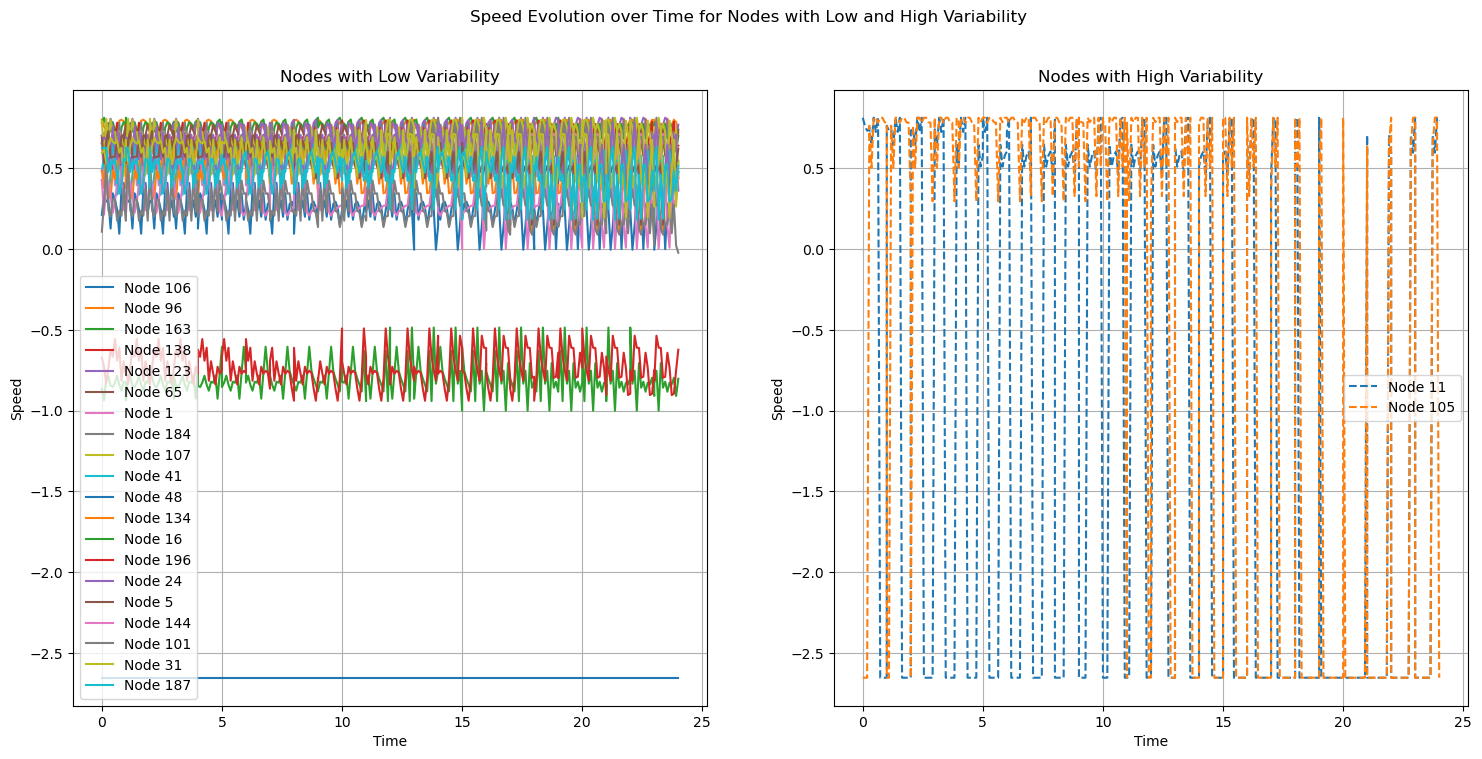

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot nodes with the lowest variability
for node in low_variability_nodes:
    node_data = merged_data[merged_data['Sensor Number'] == node]
    axs[0].plot(node_data['Time Index'] + node_data['Moment'] / node_data['Moment'].max(), node_data['Speed'], label=f'Node {node}')
axs[0].set_title('Nodes with Low Variability')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Speed')
axs[0].legend()
axs[0].grid(True)

# Plot nodes with the highest variability
for node in high_variability_nodes:
    node_data = merged_data[merged_data['Sensor Number'] == node]
    axs[1].plot(node_data['Time Index'] + node_data['Moment'] / node_data['Moment'].max(), node_data['Speed'], linestyle='--', label=f'Node {node}')
axs[1].set_title('Nodes with High Variability')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Speed')
axs[1].legend()
axs[1].grid(True)

plt.suptitle('Speed Evolution over Time for Nodes with Low and High Variability')
plt.show()


Text(0.5, 1.0, 'Variability of speed')

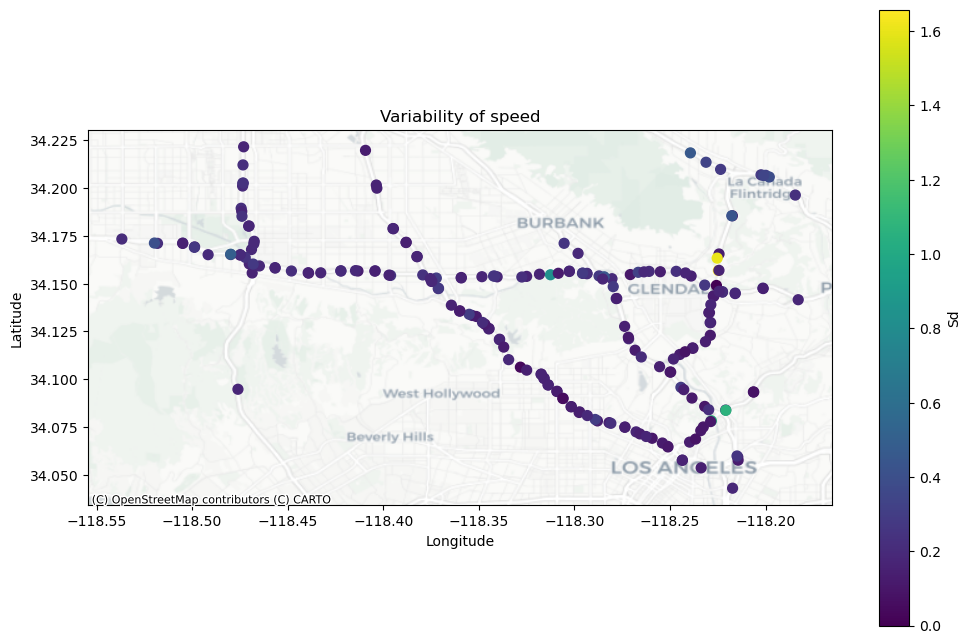

In [28]:
metadata["sd"] = node_variability
# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# set map in the background. CartoDB was selected because its cleaner to display the nodes
# color based on the speed on that moment
sc = ax.scatter(
    metadata['longitude'], metadata['latitude'],
    c=metadata['sd'], s=50
    )
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

# labels
plt.colorbar(sc, label='Sd')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Variability of speed')



In [27]:
metadata.to_csv('sd.csv', index=False)

# Network analysis

In [ ]:
import pickle

# 'latin-1' needed to open 
with open('/content/drive/MyDrive/adj_mx.pkl', 'rb') as f:
    adj_matrix = pickle.load(f, encoding='latin-1')


print(adj_matrix)  

[['773869', '767541', '767542', '717447', '717446', '717445', '773062', '767620', '737529', '717816', '765604', '767471', '716339', '773906', '765273', '716331', '771667', '716337', '769953', '769402', '769403', '769819', '769405', '716941', '717578', '716960', '717804', '767572', '767573', '773012', '773013', '764424', '769388', '716328', '717819', '769941', '760987', '718204', '718045', '769418', '768066', '772140', '773927', '760024', '774012', '774011', '767609', '769359', '760650', '716956', '769831', '761604', '717495', '716554', '773953', '767470', '716955', '764949', '773954', '767366', '769444', '773939', '774067', '769443', '767750', '767751', '767610', '773880', '764766', '717497', '717490', '717491', '717492', '717493', '765176', '717498', '717499', '765171', '718064', '718066', '765164', '769431', '769430', '717610', '767053', '767621', '772596', '772597', '767350', '767351', '716571', '773023', '767585', '773024', '717483', '718379', '717481', '717480', '717486', '764120'

In [ ]:
import networkx as nx
if isinstance(adj_matrix, list) and isinstance(adj_matrix[2], np.ndarray):
    adjacency_matrix_np = adj_matrix[2]

In [ ]:
id_nodes = pd.DataFrame({
    'node': list(adj_matrix[1].keys()),
    'index': list(adj_matrix[1].values())
})

In [ ]:
adj_matrix[2][[0]]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.22234692, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.5088465 , 0.        , 0.        ,
        0.        , 0.        , 0.13740046, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.4409315 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [ ]:
# Convertir la Matriz a un Grafo 
G = nx.from_numpy_array(adjacency_matrix_np)

# Calcular las Centralidades
degree = dict(G.degree())
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# DataFrame d
centrality_df = pd.DataFrame({
    'node': list(adj_matrix[1].keys()),
    'index': list(adj_matrix[1].values()),
    'degree': list(degree.values()),
    'degree_centrality': list(degree_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values())
})

centrality_df['node'] = centrality_df['node'].astype(int)


In [ ]:
# Merge con los metadatos para obtener las ubicaciones
network_geo = pd.merge(centrality_df, metadata, left_on='node', right_on='sensor_id')

In [ ]:
pip install folium

In [ ]:
nodes_df

,sensor_id,index_x,index_y,latitude,longitude
0,773869,0,0,34.15497,-118.31829
1,767541,1,1,34.11621,-118.23799
2,767542,2,2,34.11641,-118.23819
3,717447,3,3,34.07248,-118.26772
4,717446,4,4,34.07142,-118.26572
...,...,...,...,...,...
202,717592,202,202,34.14604,-118.22430
203,717595,203,203,34.14163,-118.18290
204,772168,204,204,34.16542,-118.47985
205,718141,205,205,34.15133,-118.37456


In [ ]:
import folium
from folium import plugins

m = folium.Map(location=[34.05, -118.25], zoom_start=10)

for idx, row in network_geo.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Node: {row['node']}<br>Degree: {row['degree']}",
    ).add_to(m)


folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl().add_to(m)


m.save('/content/drive/MyDrive/maps/mapa_interactivo.html')


m


Text(0.5, 1.0, 'Degree of nodes')

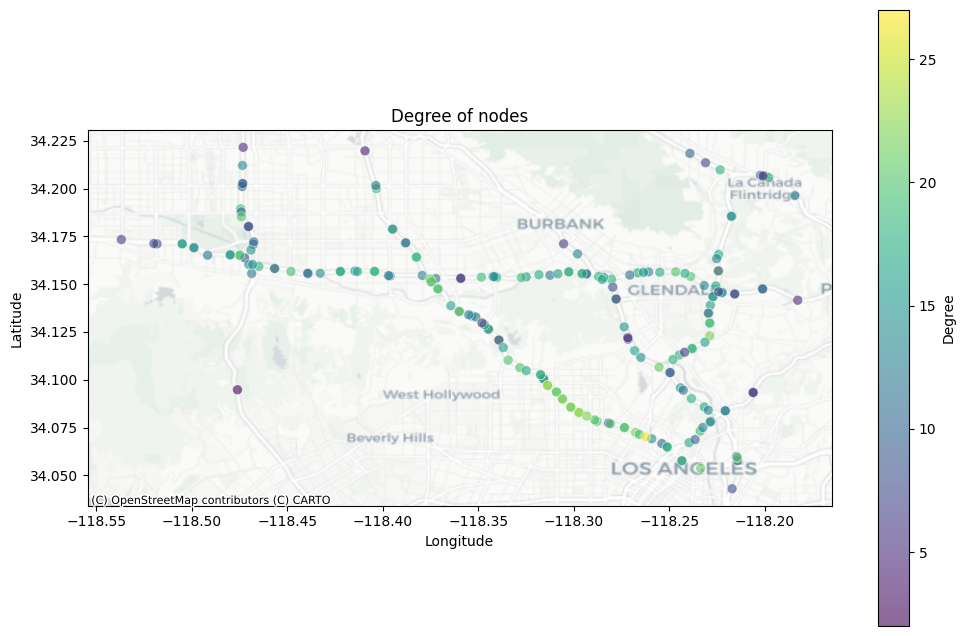

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))


sc = ax.scatter(
    network_geo['longitude'], network_geo['latitude'],
    c=network_geo['degree'], s=50,
    #cmap='viridis',
    alpha=0.6, edgecolors='w', linewidths=0.5)

ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)


plt.colorbar(sc, label='Degree')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Degree of nodes')



In [ ]:
network_geo

,node,degree,degree_centrality,closeness_centrality,betweenness_centrality,index,sensor_id,latitude,longitude
0,0,20,0.097087,0.260210,0.129941,0,773869,34.15497,-118.31829
1,1,17,0.082524,0.211185,0.028398,1,767541,34.11621,-118.23799
2,2,16,0.077670,0.201188,0.003388,2,767542,34.11641,-118.23819
3,3,19,0.092233,0.198063,0.005093,3,717447,34.07248,-118.26772
4,4,22,0.106796,0.214066,0.047428,4,717446,34.07142,-118.26572
...,...,...,...,...,...,...,...,...,...
202,202,7,0.033981,0.188719,0.000403,202,717592,34.14604,-118.22430
203,203,5,0.024272,0.175866,0.000043,203,717595,34.14163,-118.18290
204,204,14,0.067961,0.161909,0.007982,204,772168,34.16542,-118.47985
205,205,14,0.067961,0.233683,0.016899,205,718141,34.15133,-118.37456


**Graph**

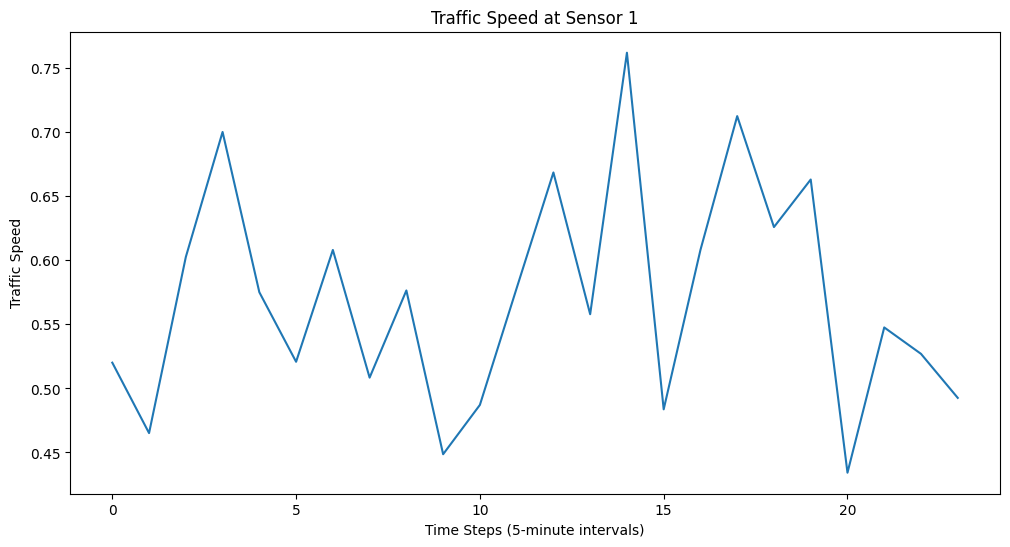

In [ ]:
sensor_number = 1
hours = 24

sensor_labels = [bucket.y[sensor_number, 10].item() for bucket in list(dataset)[:hours]]

plt.figure(figsize=(12, 6))
sns.lineplot(data=sensor_labels)
plt.title('Traffic Speed at Sensor {}'.format(sensor_number))
plt.xlabel('Time Steps (5-minute intervals)')
plt.ylabel('Traffic Speed')
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        self.tgnn = A3TGCN(in_channels=node_features, out_channels=32, periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

# params setting
node_features = 2
periods = 12

# init model
model = TemporalGNN(node_features=node_features, periods=periods)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
# data split
train_size = int(0.8 * num_snapshots)
test_size = num_snapshots - train_size
train_dataset, test_dataset = snapshot_list[:train_size], snapshot_list[train_size:]

# train
def train(model, train_dataset):
    model.train()
    total_loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        optimizer.zero_grad()
        y_hat = model(snapshot.x, snapshot.edge_index)
        loss = torch.mean((y_hat - snapshot.y)**2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        step += 1
    return total_loss / step

# eval
def evaluate(model, test_dataset):
    model.eval()
    total_loss = 0
    step = 0
    with torch.no_grad():  # Disable gradient calculation
        for snapshot in test_dataset:
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index)
            loss = torch.mean((y_hat - snapshot.y)**2)
            total_loss += loss.item()
            step += 1
    return total_loss / step

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training and evaluating the model
epochs = 2
for epoch in range(epochs):
    train_loss = train(model, train_dataset)
    test_loss = evaluate(model, test_dataset)
    print(f"Epoch {epoch + 1}, Train MSE: {train_loss:.4f}, Test MSE: {test_loss:.4f}")


Epoch 1, Train MSE: 0.5100, Test MSE: 1.1990
Epoch 2, Train MSE: 0.5126, Test MSE: 1.2036


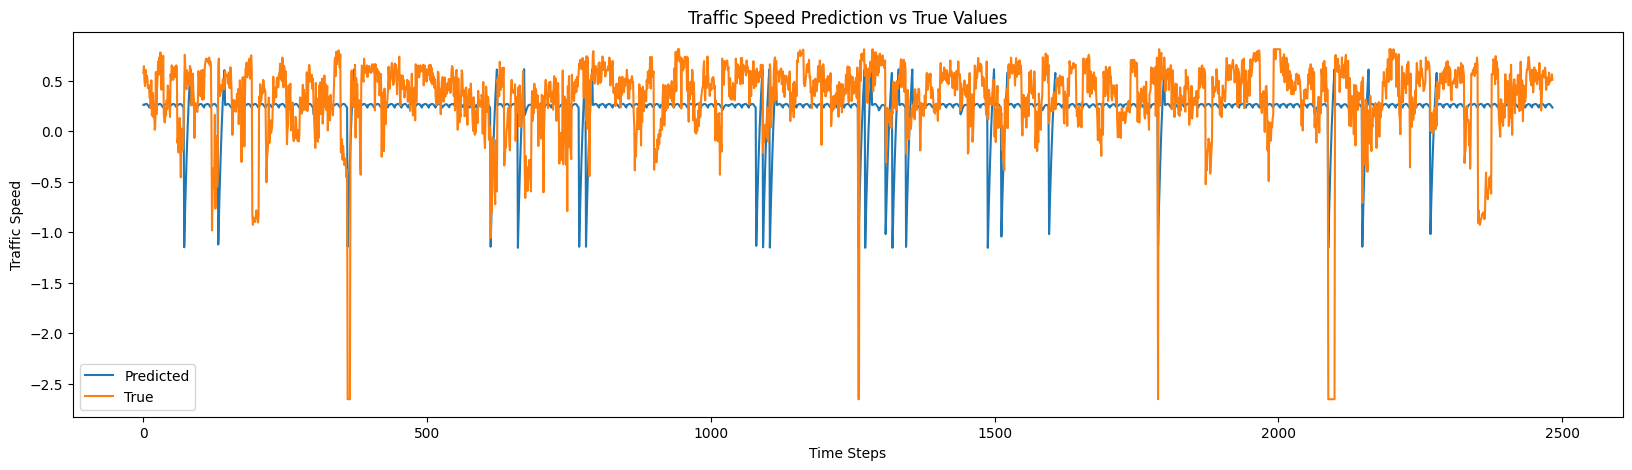

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a snapshot from the test set for prediction and visualization
snapshot = test_dataset[0]
snapshot = snapshot.to(device)
model.eval()
y_hat = model(snapshot.x, snapshot.edge_index).detach().cpu().numpy()
y_true = snapshot.y.cpu().numpy()

# Plotting the predictions and true values
plt.figure(figsize=(20, 5))
sns.lineplot(data=y_hat.flatten(), label='Predicted')
sns.lineplot(data=y_true.flatten(), label='True')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Speed')
plt.title('Traffic Speed Prediction vs True Values')
plt.legend()
plt.show()
